# Flux / Mass Plots

Original version done for proposal in ~2018

Updated version using Theo's models at the bottom

In [1]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'white'

In [2]:
from astropy.table import Table
from sedfitter.sed import SEDCube
from astropy import units as u

In [3]:
os.chdir('/blue/adamginsburg/richardson.t/research/flux/robitaille_models/')

In [4]:
modeltype = 's-pbhmi'

seds = SEDCube.read('{modeltype}/flux.fits'.format(**locals()))
pars = Table.read('{modeltype}/parameters.fits'.format(**locals()))

## Original estimates

The 2018 version of this did some very simply power-law estimates of the mass

In [5]:
azero = np.abs(pars['envelope.power'])
rmin = u.Quantity(pars['envelope.rmin'], u.cm)
rhoout = u.Quantity(pars['ambient.density'], u.g/u.cm**3)
rho_0 = u.Quantity(pars['envelope.rho_0'], u.g/u.cm**3)
r_min = u.Quantity(pars['envelope.rmin'], u.cm)
r_0 = 1000*u.AU
# this is the full extent r_out
rout = (rhoout/rho_0)**(-1/azero)*r_0
# we actually want to integrate to a given aperture...
# so we'll calculate the masses in _each_ aperture, making a 2d array of masses using numpy broadcasting tricks
# or... we'll just use one aperture.
#rout_ap = seds.apertures[None,:]
rout_ap = seds.apertures[5] # see below

The mass estimates take the total dust mass assuming a pure power-law profile, which is at least somewhat appropriate for the `s-phbhmi` geometry.

In [6]:
mass_total = 4*np.pi*rho_0*(r_0.to(u.cm).value**azero)*(rout.to(u.cm).value**(3-azero)-rmin.to(u.cm).value**(3-azero))/(3-azero) * u.cm**3
mass_aperture = 4*np.pi*rho_0*(r_0.to(u.cm).value**azero)*(rout_ap.to(u.cm).value**(3-azero)-rmin.to(u.cm).value**(3-azero))/(3-azero) * u.cm**3

In [7]:
m_gas = (mass_aperture*100).to(u.M_sun)

# sanity check the first row
mass_total[0], mass_aperture[0], m_gas[0], rhoout[0], rho_0[0], r_min[0], rout[0], (rho_0[0]*(r_min[0] / r_0)**(-azero[0])).to(u.g/u.cm**3)

(<Quantity 1.83596251e+32 g>,
 <Quantity 3.26678922e+28 g>,
 <Quantity 0.00164292 solMass>,
 <Quantity 1.e-23 g / cm3>,
 <Quantity 1.195e-21 g / cm3>,
 <Quantity 2.216 cm>,
 <Quantity 94746.50155985 AU>,
 <Quantity 5.17631503e-05 g / cm3>)

The subsequent plots are just sanity checks

Text(0, 0.5, 'Number of models')

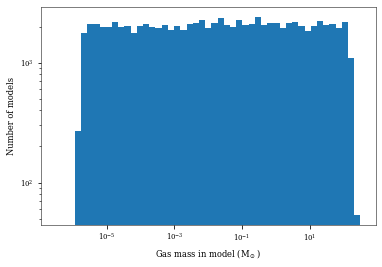

In [8]:
pl.hist(m_gas.value, bins=np.logspace(-6.5,2.5), log=True)
pl.loglog()
pl.xlabel("Gas mass in model (M$_\odot$)")
pl.ylabel("Number of models")

In [9]:
obsfreq = 230*u.GHz
obsfreq_ind = np.argmin(np.abs(seds.wav - obsfreq.to(u.um, u.spectral())))
obsfreq_ind, seds.wav[obsfreq_ind]

(20, <Quantity 1302.64347351 um>)

In [10]:
aperture_ind = 5
seds.apertures[aperture_ind]

<Quantity 1128.83789168 AU>

Flux at 1mm vs gas mass:

Text(0, 0.5, '$S_{\\nu}$ (1 mm)')

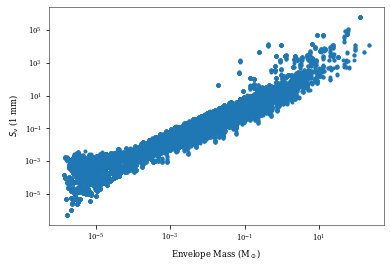

In [11]:
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.')
pl.xlabel("Envelope Mass (M$_\odot$)")
pl.ylabel(r"$S_{\nu}$ (1 mm)")

Zoom in to cut off the low-mass end 

[0.1, 200, 0.1, 1000000.0]

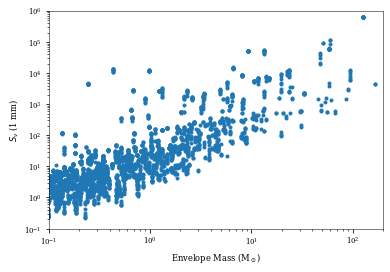

In [12]:
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.')
pl.xlabel("Envelope Mass (M$_\odot$)")
pl.ylabel(r"$S_{\nu}$ (1 mm)")
pl.axis([0.1, 200, 0.1, 1e6])

# Comparison of "isothermal" mass to "real" mass

In [13]:
import dust_emissivity

In [14]:
m_gas_u = np.unique(m_gas)
predicted_flux_20K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=20*u.K)
predicted_flux_50K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=50*u.K)
predicted_flux_10K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=10*u.K)

This is the meaty plot:

Left, we plot the flux vs core mass for the models.  We overlay the predicted flux assuming optically thin dust at a given temperature in three colors.

We then take the ratio of the grey points to those predicted models.

Right, we plot the ratio of those ratios.  These are the multiplicative correction factors that must be applied to the optically thin models to get to the correct models: i.e., they are an estimate of how wrong the optically thin, isothermal assumption is at 20K.

The maroon curve shows only the M>10 Msun models, while the blue shows M<1 Msun models, highlighting that there are different biases in the two samples.

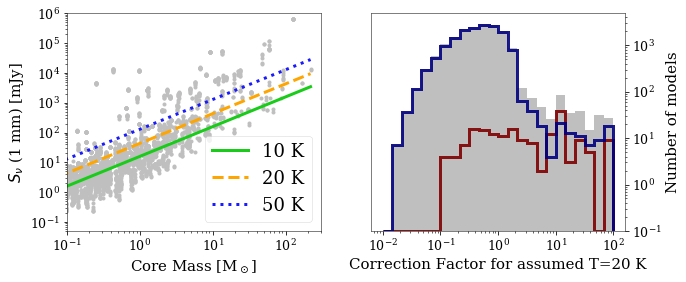

In [15]:
pl.rcParams['font.size'] = 18

pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.', color=(0.75,0.75,0.75))
pl.loglog(m_gas_u.value, predicted_flux_10K.to(u.mJy).value, '-', color=(0.1,0.8,0.1), label='10 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_20K.to(u.mJy).value, '--', color='orange', label='20 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_50K.to(u.mJy).value, ':', color=(0.1,0.1,1), label='50 K', linewidth=3)

pl.xlabel("Core Mass [M$_\odot$]")
pl.ylabel(r"$S_{\nu}$ (1 mm) [mJy]")
pl.axis([0.1, 300, 0.05, 1e6])
pl.legend(loc='best')

ax = pl.subplot(1,2,2)
correction_factor_20K = (seds.val[:, aperture_ind, obsfreq_ind] / dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas, temperature=20*u.K)).decompose()
bins = np.logspace(-2, 2, 25)
pl.hist(correction_factor_20K, bins=bins, log=True,
        color='gray', alpha=0.5, histtype='stepfilled')
pl.hist(correction_factor_20K[m_gas > 10*u.M_sun],
        bins=bins, log=True, color='maroon', histtype='step', linewidth=3, alpha=0.9)
pl.hist(correction_factor_20K[m_gas < 1*u.M_sun],
        bins=bins, log=True, color='navy', histtype='step', linewidth=3, alpha=0.9)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
_ = pl.loglog()
pl.ylabel("Number of models")
_ = pl.xlabel("Correction Factor for assumed T=20 K")
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux.pdf", bbox_inches='tight')
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux.png", bbox_inches='tight')

# Do it again, but with Theo's corrected mass calculations

In [16]:
ls /blue/adamginsburg/richardson.t/research/flux/pars

all_tables.fits         s-p-smi_augmented.fits  s---smi_augmented.fits
s-pbhmi_augmented.fits  sp--smi_augmented.fits  s-ubhmi_augmented.fits
s-pbsmi_augmented.fits  spubhmi_augmented.fits  s-ubsmi_augmented.fits
sp--h-i_augmented.fits  spubsmi_augmented.fits  s-u-hmi_augmented.fits
s-p-hmi_augmented.fits  spu-hmi_augmented.fits  s-u-smi_augmented.fits
sp--hmi_augmented.fits  spu-smi_augmented.fits
sp--s-i_augmented.fits  s---s-i_augmented.fits


In [17]:
modeltype = 's-pbhmi'

seds = SEDCube.read('{modeltype}/flux.fits'.format(**locals()))
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{modeltype}_augmented.fits')

In [18]:
m_gas = u.Quantity(pars['Line-of-Sight Masses'][:,5], u.M_sun)
m_gas_u = np.unique(m_gas)

predicted_flux_20K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=20*u.K)
predicted_flux_50K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=50*u.K)
predicted_flux_10K = dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas_u, temperature=10*u.K)

m_gas.shape, m_gas_u.shape

((90000,), (82425,))

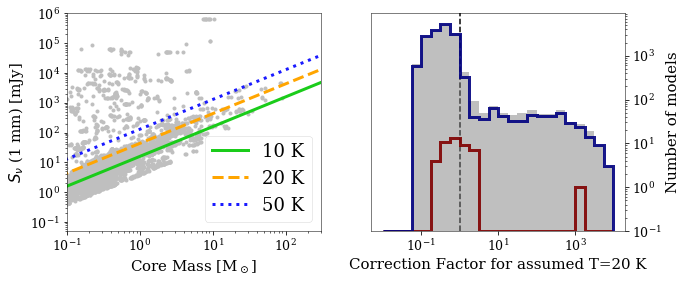

In [19]:
pl.rcParams['font.size'] = 18

pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.', color=(0.75,0.75,0.75))
pl.loglog(m_gas_u.value, predicted_flux_10K.to(u.mJy).value, '-', color=(0.1,0.8,0.1), label='10 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_20K.to(u.mJy).value, '--', color='orange', label='20 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_50K.to(u.mJy).value, ':', color=(0.1,0.1,1), label='50 K', linewidth=3)

pl.xlabel("Core Mass [M$_\odot$]")
pl.ylabel(r"$S_{\nu}$ (1 mm) [mJy]")
pl.axis([0.1, 300, 0.05, 1e6])
pl.legend(loc='best')

ax = pl.subplot(1,2,2)
correction_factor_20K = (seds.val[:, aperture_ind, obsfreq_ind] / dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas, temperature=20*u.K)).decompose()
bins = np.logspace(-2, 4, 25)
pl.hist(correction_factor_20K, bins=bins, log=True,
        color='gray', alpha=0.5, histtype='stepfilled')
pl.hist(correction_factor_20K[m_gas > 10*u.M_sun],
        bins=bins, log=True, color='maroon', histtype='step', linewidth=3, alpha=0.9)
pl.hist(correction_factor_20K[m_gas < 1*u.M_sun],
        bins=bins, log=True, color='navy', histtype='step', linewidth=3, alpha=0.9)
ax.axvline(1, linestyle='--', color='k', zorder=-5)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
_ = pl.loglog()
pl.ylabel("Number of models")
_ = pl.xlabel("Correction Factor for assumed T=20 K")
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux_Theo.pdf", bbox_inches='tight')
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux_Theo.png", bbox_inches='tight')

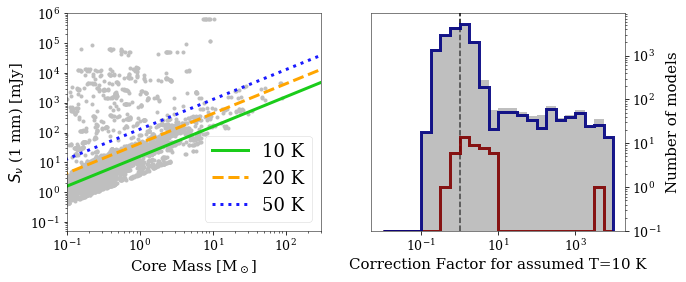

In [23]:
pl.rcParams['font.size'] = 18

pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.', color=(0.75,0.75,0.75))
pl.loglog(m_gas_u.value, predicted_flux_10K.to(u.mJy).value, '-', color=(0.1,0.8,0.1), label='10 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_20K.to(u.mJy).value, '--', color='orange', label='20 K', linewidth=3)
pl.loglog(m_gas_u.value, predicted_flux_50K.to(u.mJy).value, ':', color=(0.1,0.1,1), label='50 K', linewidth=3)

pl.xlabel("Core Mass [M$_\odot$]")
pl.ylabel(r"$S_{\nu}$ (1 mm) [mJy]")
pl.axis([0.1, 300, 0.05, 1e6])
pl.legend(loc='best')

ax = pl.subplot(1,2,2)
correction_factor_10K = (seds.val[:, aperture_ind, obsfreq_ind] / dust_emissivity.dust.snuofmass(nu=obsfreq, mass=m_gas, temperature=10*u.K)).decompose()
bins = np.logspace(-2, 4, 25)
pl.hist(correction_factor_10K, bins=bins, log=True,
        color='gray', alpha=0.5, histtype='stepfilled')
pl.hist(correction_factor_10K[m_gas > 10*u.M_sun],
        bins=bins, log=True, color='maroon', histtype='step', linewidth=3, alpha=0.9)
pl.hist(correction_factor_10K[m_gas < 1*u.M_sun],
        bins=bins, log=True, color='navy', histtype='step', linewidth=3, alpha=0.9)
ax.axvline(1, linestyle='--', color='k', zorder=-5)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
_ = pl.loglog()
pl.ylabel("Number of models")
_ = pl.xlabel("Correction Factor for assumed T=10 K")
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux_Theo_10K.pdf", bbox_inches='tight')
pl.savefig(f"/orange/adamginsburg/robitaille_models/modelgrids/figures/{modeltype}_models_mass_flux_Theo_10K.png", bbox_inches='tight')

## These plots are useful!

The M>10 Msun models are, on average, more consistent with ~20K.

The M<1 Msun models are, on average, more consistent with ~10K.

However, if we look at the plots below, there might be a lot of sampling bias contributing to this.

Here's the mass vs 1mm flux plot from above:

Text(0, 0.5, '$S_{\\nu}$ (1 mm)')

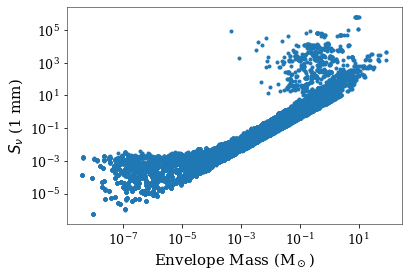

In [24]:
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.')
pl.xlabel("Envelope Mass (M$_\odot$)")
pl.ylabel(r"$S_{\nu}$ (1 mm)")

[0.1, 200, 0.1, 1000000.0]

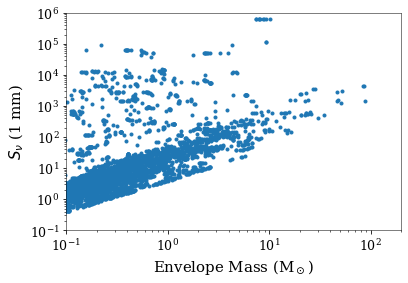

In [25]:
pl.loglog(m_gas.value, seds.val[:, aperture_ind, obsfreq_ind], '.')
pl.xlabel("Envelope Mass (M$_\odot$)")
pl.ylabel(r"$S_{\nu}$ (1 mm)")
pl.axis([0.1, 200, 0.1, 1e6])